# Reparameterization Trick

## 0. Iniitialize

In [1]:
#mathematics
using LinearAlgebra
using ForwardDiff
using Flux

#statistics
using Random
using Distributions
using Statistics

#visualize
using Plots
pyplot()

#macros
using UnPack
using ProgressMeter

## 1. Define variational inference

In [2]:
#split parameters
function split_params(vec)
    return vec[1:2], vec[3:end]
end

#reparametrize
function reparameterize(var_mean,var_logstd)
    var_mean + exp.(var_logstd) .* randn(2)
end

#logpmodel
function logpmodel(y,x,wvec)
    logpdf(Bernoulli(sigmoid(wvec[1]+wvec[2]*x)),y)
end

#ELBO
function ELBO(X,Y,ηvec,minibatch,m₀vec,s₀,N)
    val = 0
    for n in minibatch
        var_mean,var_logstd = split_params(ηvec)
        val += logpmodel(Y[n],X[n],reparameterize(var_mean,var_logstd))
    end
    return N*val/length(minibatch)-(norm(ηvec[1:2]-m₀vec)^2+norm(exp.(ηvec[3:end]))^2)/2/s₀^2+sum(ηvec[3:end])+(1-2*log(s₀))
end
ELBO(X,Y,ηvec,m₀vec,s₀,N) = ELBO(X,Y,ηvec,1:length(X),m₀vec,s₀,N)

#create model
function create_model(X,Y,m₀vec,s₀,N)
    ηvec = zeros(4)
    ps = Flux.params(ηvec)
    loss_func = minibatch->(-ELBO(X,Y,ηvec,minibatch,m₀vec,s₀,N))
    return ηvec,ps,loss_func
end

#stochastic variational inference
function stochastic_variational_inference(data,model_params,n_train,minibatch_size)
    @unpack X,N = data
    @unpack m₀vec,s₀ = model_params
    opt = ADAM(0.01)
    history = zeros(n_train)
    ηvec,ps,loss_func = create_model(X,Y,m₀vec,s₀,N)
    @showprogress for k in 1:n_train
        minibatch = sample(1:N,minibatch_size)
        Flux.train!(loss_func,ps,minibatch,opt)
        history[k] = ELBO(X,Y,ηvec,m₀vec,s₀,N)
    end
    return ηvec,history
end

stochastic_variational_inference (generic function with 1 method)

## 2. Define functions

In [3]:
#log likelihood
function loglik(X,Y,N,wvec)
    val = 0
    for n in 1:N
        val += logpmodel(Y[n],X[n],wvec)
    end
    val
end

#reconstruction error using reconstruction error
function loglik_RP(ηvec,X,Y,N,normal_samp)
    var_mean,var_logstd = split_params(ηvec)
    loglik(X,Y,N,var_mean+exp.(var_logstd).*normal_samp)
end

#one sample for monte carlo estimate  : reparameterization trick
function MC_sample_RP(ηvec,X,Y,N,S)
    MC_samps = zeros(4,S)
    normal_samps = randn(2,S)
    for s in 1:S
        MC_samps[:,s] = ForwardDiff.gradient(ηvec->loglik_RP(ηvec,X,Y,N,normal_samps[:,s]),ηvec)
    end
    return mean(MC_samps,dims=2)
end

#log rη(wvec)
function logrηwvec(ηvec,wvec)
    var_mean,var_logstd = split_params(ηvec)
    logpdf(MvNormal(var_mean,exp.(var_logstd)),wvec)
end

#one sample for monte carlo estimate : score function estimator
function MC_sample_score(ηvec,X,Y,N,S)
    MC_samps = zeros(4,S)
    var_mean,var_logstd = split_params(ηvec)
    var_samps = var_mean .+ exp.(var_logstd) .* randn(2,S)
    for s in 1:S
        MC_samps[:,s] = (
            loglik(X,Y,N,var_samps[:,s])*ForwardDiff.gradient(ηvec->logrηwvec(ηvec,var_samps[:,s]),ηvec)
            )
    end
    return mean(MC_samps,dims=2)
end

#compute M samples of monte carlo estimate
function comp_MC_samps(m_max,ηvec,X,Y,N,S,MC_sample_func)
    MC_samps = zeros(4,m_max)
    for m in 1:m_max
        MC_samps[:,m] = MC_sample_func(ηvec,X,Y,N,S)
    end
    return MC_samps
end

#compute estimate of sample mean and sample std of the gradient
function mean_and_std_of_grad(data,S_max,m_max,ηvec,MC_sample_func)
    @unpack X,Y,N = data
    MC_samps = zeros(4,m_max)
    means = zeros(4,S_max)
    stds = zeros(4,S_max)
    @showprogress for S in 1:S_max
        MC_samps = comp_MC_samps(m_max,ηvec,X,Y,N,S,MC_sample_func)
        means[:,S] = mean(MC_samps,dims=2)
        stds[:,S] = std(MC_samps,dims=2)
    end
    return means,stds
end
mean_and_std_of_grad_RP(data,S_max,m_max,ηvec) = mean_and_std_of_grad(data,S_max,m_max,ηvec,MC_sample_RP)
mean_and_std_of_grad_score(data,S_max,m_max,ηvec) = mean_and_std_of_grad(data,S_max,m_max,ηvec,MC_sample_score)

mean_and_std_of_grad_score (generic function with 1 method)

## 3. Experiments

In [4]:
#create data
Random.seed!(42)
w₁ = -4.0
w₂ = 4.0
w_true = (w₁=w₁,w₂=w₂)
N = 30
X = sort(rand(-10:10,N))
Y = [rand(Bernoulli(sigmoid(w₁+w₂*X[n]))) for n in 1:N]

function true_pdf(y,x,w_true)
    @unpack w₁,w₂ = w_true
    pdf(Bernoulli(sigmoid(w₁+w₂*x)),y)
end

#data and model parameters
data = (X=X,Y=Y,N=N)
model_params = (m₀vec=zeros(2),s₀=1)

#training
n_train = 100
minibatch_size = N
@time ηvec,history = stochastic_variational_inference(data,model_params,n_train,minibatch_size)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


 30.134403 seconds (64.55 M allocations: 3.687 GiB, 4.24% gc time, 98.82% compilation time)


([-0.6204773814706036, 1.497324491844032, -0.4322866970845599, -0.8147137698023725], [-25.270284148792534, -20.723805318606363, -11.951259057780828, -13.933649927533455, -11.92282081923084, -5.551934547448946, -7.562388044123665, -4.810543619522835, -5.117553368072237, -7.0478866182602715  …  -2.8485365566571677, -2.2546889025907104, -3.1869641430425695, -2.878036085198189, -3.3086944000118983, -2.641987906296669, -3.1739388478770856, -3.5834747315908606, -2.7447251401026884, -3.653902779620677])

In [5]:
#maximum n_sample and n_sample of monte carlo estimate
S_max = 100
m_max = 500
means_score,stds_score = mean_and_std_of_grad_score(data,S_max,m_max,ηvec)
means_RP,stds_RP = mean_and_std_of_grad_RP(data,S_max,m_max,ηvec)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


([-0.4051565916674556 -0.42733191345258925 … -0.4394873345461976 -0.4421000432533164; 1.3823352347756088 1.4449515672436333 … 1.3789566560999922 1.3452571854449868; -0.23758667437821623 -0.31417148103466996 … -0.2914944235544722 -0.2879670895983043; -0.7456822466762585 -0.8323897654049166 … -0.7260181010314162 -0.6873117726784058], [0.5149465879625579 0.42141107708136105 … 0.05568502318097326 0.052256118861315246; 3.0117472638539002 2.6920753732892897 … 0.3234312924454245 0.3048938685385037; 0.4825839764384278 0.48914810243244367 … 0.06497275089769701 0.05989922091796125; 3.7800627003929885 3.6748453369598275 … 0.4539617603273389 0.4292511954587106])

## 4. Visualize the results

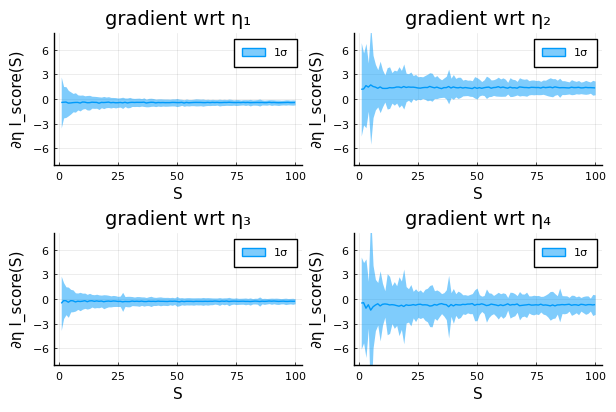

In [6]:
p_score_1 = plot(means_score[1,:],ribbons=stds_score[1,:],title="gradient wrt η₁")
p_score_2 = plot(means_score[2,:],ribbons=stds_score[2,:],title="gradient wrt η₂")
p_score_3 = plot(means_score[3,:],ribbons=stds_score[3,:],title="gradient wrt η₃")
p_score_4 = plot(means_score[4,:],ribbons=stds_score[4,:],title="gradient wrt η₄")
fig1 = plot(p_score_1,p_score_2,p_score_3,p_score_4,label="1σ",ylim=(-8,8),xlabel="S",ylabel="∂η I_score(S)")
savefig(fig1,"figs-RP/fig1.png")

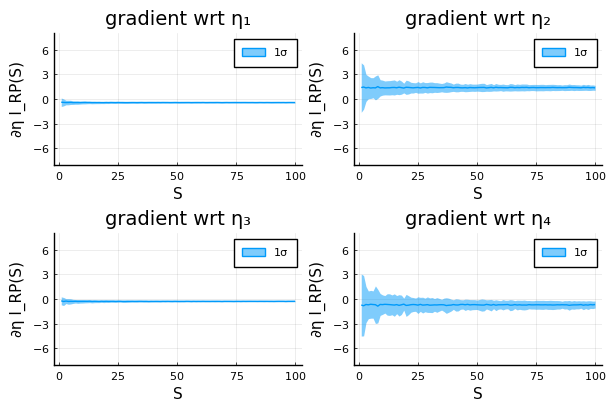

In [7]:
p_RP_1 = plot(means_RP[1,:],ribbons=stds_RP[1,:],title="gradient wrt η₁")
p_RP_2 = plot(means_RP[2,:],ribbons=stds_RP[2,:],title="gradient wrt η₂")
p_RP_3 = plot(means_RP[3,:],ribbons=stds_RP[3,:],title="gradient wrt η₃")
p_RP_4 = plot(means_RP[4,:],ribbons=stds_RP[4,:],title="gradient wrt η₄")
fig2 = plot(p_RP_1,p_RP_2,p_RP_3,p_RP_4,label="1σ",ylim=(-8,8),xlabel="S",ylabel="∂η I_RP(S)")
savefig(fig2,"figs-RP/fig2.png")